# Create a backtest with bt

A backtest is a way to test trading ideas against historic market data. It’s a simulation of how the strategy might have performed in the market. Usually, traders will optimize performance metrics like Sharpe ratio by tweaking the input parameters like the lookback periods.

Unfortunately, most beginners spend all their time tweaking backtests only to find they don’t work in real life. Even with out-of-sample data, cross-validation, and walk-forward analysis, backtest results are often way off. The majority of trading systems with a positive backtest are actually unprofitable.

Why?

### Treat backtesting as an experiment

Suppose your strategy has 0 expected profit (i.e. it trades randomly) but you don’t know it. A random strategy will produce positive results in 50% of cases and negative results in 50% of cases. Results will rarely be 0.

What do most people do with a negative backtest result? Tweak the parameters until it’s positive. To get around this problem, professionals will backtest their backtest.

I’m going to show you how.

Here's what we'll cover:

- Set up a backtest with bt
- Run a backtest and analyze results
- Perform a Monte Carlo simulation on your backtest

### Step 1: Imports and set up

bt is a flexible backtesting framework for Python used to test quantitative trading strategies. Import NumPy and Matplotlib too.

In [27]:
%matplotlib inline
import bt
import matplotlib.pyplot as plt

Fund managers report their holdings every month. They don’t want to tell investors that they lost money the latest meme stock. So they will sell the meme stocks and buy higher quality assets, like bonds.

We might be able to take advantage of this effect by buying bonds toward the end of the month and selling them at the beginning.

Start by getting data for the bond ETF, TLT.

In [28]:
data = bt.get("tlt", start="2010-01-01", end="2022-06-30")

Then create six functions to run the backtest.

In [29]:
def build_strategy(weights):
    return bt.Strategy(
        'wd', 
        [bt.algos.SelectAll(), 
         bt.algos.WeighTarget(weights), 
         bt.algos.Rebalance()]
    )

The first takes daily portfolio weights. bt has a library of built in algos which takes care of the logic for you. This function weights the portfolio based on the input and rebalance daily.

In [30]:
def build_backtest(strategy, df, initial_capital, commission_model):
    return bt.Backtest(strategy,
        df,
        initial_capital=initial_capital,
        commissions=commission_model,

    )

The next function takes the strategy you just built, market data, initial capital, and a commission model.

In [31]:
# a simple commission model
def commission_model(q, p):
    
    # p is price, q is quantity
    val = abs(q * p)
    if val > 2000:
        return 8.6
    if val > 1000:
        return 4.3
    if val > 100:
        return 1.5
    return 1.0

initial_capital = 10_000

Your commission model can be anything you want. It just needs price and quantity.

In [32]:
def add_dom(df):
    
    # add the day of month and return
    added = df.copy()
    added["day_of_month"] = df.index.day
    return added

Next, create a function that adds a column to the DataFrame with the day of the month. I want to be long TLT for the last week of the month and short during first. To do this, I need to know the day of month.

In [33]:
def add_weights(df, symbol):
    
    # start with no position within the month
    strategy = df[[symbol]].copy()
    
    # start with no position within the month
    strategy.loc[:] = 0
    
    # short within the first week of the month
    strategy.loc[df.day_of_month <= 7] = -1

    # long during the last week of the month
    strategy.loc[df.day_of_month >= 23] = 1
    
    return strategy

The last function weights the portfolio 100% short during the first week of the month and 100% long during the last week of the month. All other days the strategy is out of the market.

In [34]:
initial_capital = 10_000

Finally, set the initial capital.

### Step 2: Run the initial backtest

Now that everything is in place, run the backtest.

In [36]:
# add the day of month
data_with_dom = add_dom(data)

# get the portfolio weights
weights = add_weights(data_with_dom, 'tlt')

# build the bt strategy
strategy = build_strategy(weights)

#build the backtest
backtest = build_backtest(strategy, data, initial_capital, commission_model)

#run the backtest
first_res = bt.run(backtest)


/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)


This code will setup the strategy and run the backtest. bt makes it easy to see the results.

In [37]:
first_res.display()

Stat                 wd
-------------------  ----------
Start                2010-01-03
End                  2022-06-30
Risk-free rate       0.00%

Total Return         79.51%
Daily Sharpe         0.50
Daily Sortino        0.79
CAGR                 4.80%
Max Drawdown         -19.30%
Calmar Ratio         0.25

MTD                  2.17%
3m                   7.09%
6m                   13.99%
YTD                  13.77%
1Y                   22.65%
3Y (ann.)            10.93%
5Y (ann.)            6.35%
10Y (ann.)           4.36%
Since Incep. (ann.)  4.80%

Daily Sharpe         0.50
Daily Sortino        0.79
Daily Mean (ann.)    5.23%
Daily Vol (ann.)     10.44%
Daily Skew           -0.05
Daily Kurt           6.10
Best Day             3.95%
Worst Day            -5.28%

Monthly Sharpe       0.53
Monthly Sortino      0.91
Monthly Mean (ann.)  5.10%
Monthly Vol (ann.)   9.64%
Monthly Skew         -0.39
Monthly Kurt         3.23
Best Month           11.20%
Worst Month          -12.02%

Yearly S

This prints performance statistics about the strategy. Make note of the daily Sharpe which we’ll use next.

bt makes it easy to plot the results, too.

<AxesSubplot: title={'center': 'Equity Progression'}>

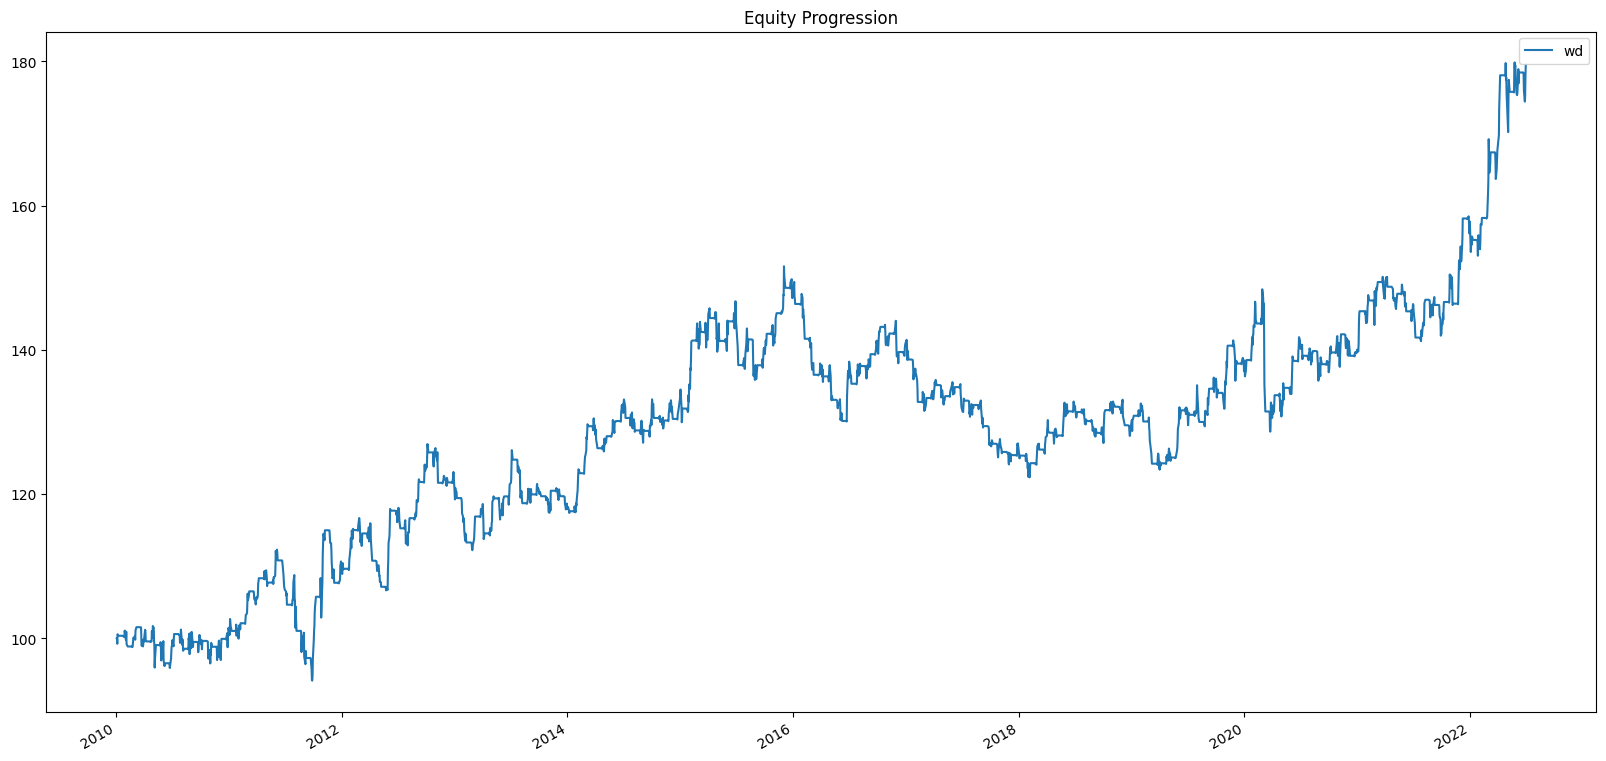

In [38]:
first_res.plot(figsize=(20, 10))

And the weights.

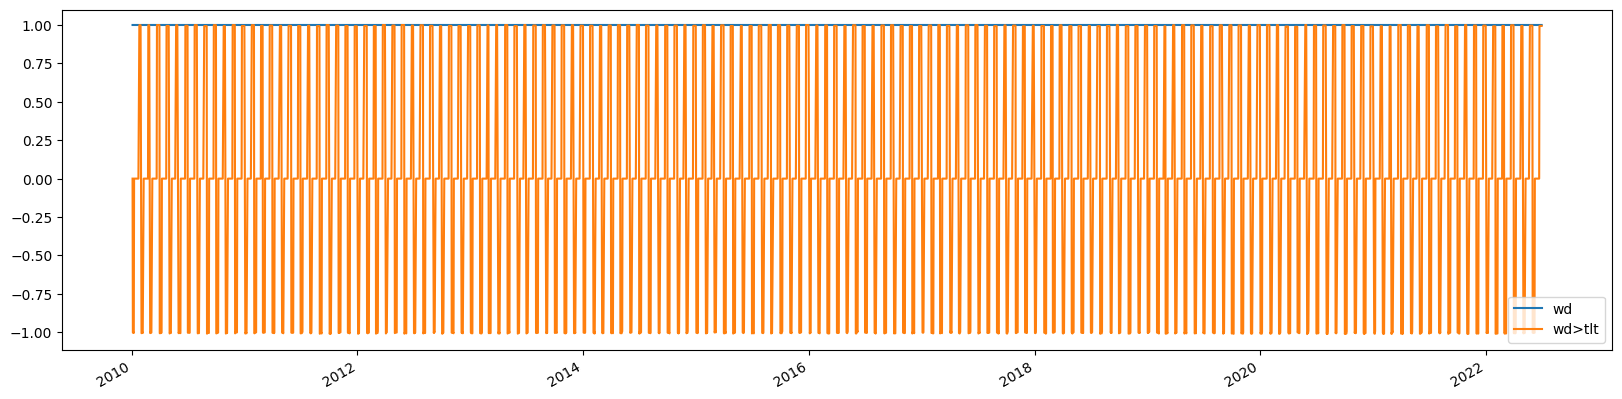

In [39]:
first_res.plot_weights('wd', figsize=(20, 5))

### Step 3: Backtest the backtest

We need one more function.

In [40]:
def shuffle_prices(df):
    
    # randomly shuffle the prices without replacement
    shuffled = df.sample(frac=1)
    
    # reset the index
    shuffled.index = df.index
    
    return shuffled

This shuffles the prices and resets the date index.

Why do we do this?

I’m going to run a simulation of 100 backtests (you should use more). I plot the resulting Sharpe ratios and see where our backtest result is on the distribution. This gives me an idea of how far away from the mean the backtest result it. In other words, how random was the first result.

In [41]:
runs = 100
initial_sharpe = first_res['wd'].daily_sharpe
sharpes = []

Set the number of runs and grab the daily Sharpe ratio from the first backtest. Finally, create a list to capture the Sharpe ratios.

In [43]:
for run in range(0, runs):
    
    # shuffle the prices
    shuffled = shuffle_prices(data)
    
    # add the day of month
    shuffled_with_dom = add_dom(shuffled)
    
    # add the weights
    weights = add_weights(shuffled_with_dom, 'tlt')
    
    # build the strategy
    strategy = build_strategy(weights)
    
    # build the backtest
    backtest = build_backtest(strategy, shuffled_with_dom, initial_capital, commission_model)
    
    # run the backtest
    res = bt.run(backtest)
    
    # accumulate sharpe ratios
    sharpe = res['wd'].daily_sharpe
    sharpes.append(sharpe)

/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:1376: RuntimeWarning: invalid value encountered in double_scalars
  return (prices.iloc[-1] / prices.iloc[0]) ** (1 / year_frac(start, end)) - 1
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value 

/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwarg

/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:1376: RuntimeWarning: invalid value encountered in double_scalars
  return (prices.iloc[-1] / prices.iloc[0]) ** (1 / year_frac(start, end)) - 1
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:1376: RuntimeWarning: invalid value encountered in double_scalars
  return (prices.iloc[-1] / prices.iloc[0]

/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda

/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:1376: RuntimeWarning: invalid value encountered in double_scalars
  return (prices.iloc[-1] / prices.iloc[0]) ** (1 / year_frac(start, end)) - 1
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:1376: RuntimeWarning: invalid value encountered in double_scalars
  return (prices.iloc[-1] / prices.iloc[0]

/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda

/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:1376: RuntimeWarning: invalid value encountered in double_scalars
  return (prices.iloc[-1] / prices.iloc[0]) ** (1 / year_frac(start, end)) - 1
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:1376: RuntimeWarning: invalid value encountered in double_scalars
  return (prices.iloc[-1] / prices.iloc[0]

/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:1376: RuntimeWarning: invalid value encountered in double_scalars
  return (prices.iloc[-1] / prices.iloc[0]) ** (1 / year_frac(start, end)) - 1
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:1376: RuntimeWarning: invalid value encountered in double_scalars
  return (prices.iloc[-1] / prices.iloc[0]) ** (1 / year_frac(start, end)) - 1
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecate

/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwarg

/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwarg

/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda

/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda

/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:1376: RuntimeWarning: invalid value encountered in double_scalars
  return (prices.iloc[-1] / prices.iloc[0]) ** (1 / year_frac(start, end)) - 1
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/future/utils/__init__.py:312: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kw

/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:1376: RuntimeWarning: invalid value encountered in double_scalars
  return (prices.iloc[-1] / prices.iloc[0]) ** (1 / year_frac(start, end)) - 1
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: invalid value encountered in divide
  res = np.divide(er.mean(), std)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jason/opt/anaconda3/envs/backtrader/lib/python3.9/site-packages/ffn/core.py:1376: RuntimeWarning: invalid value encountered in double_scalars
  return (prices.iloc[-1] / prices.iloc[0]

This loop runs the backtest against randomly shuffled prices. It then accumulates the Sharpe ratios which are based on the random data.

Finally, find out where the Sharpe ratio is in the distribution of random backtest results.

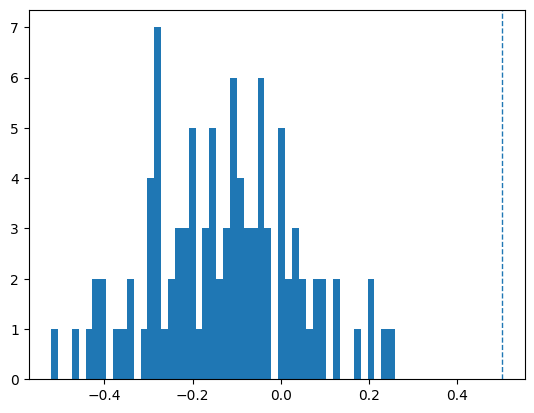

In [44]:
dist = plt.hist(sharpes, bins=50)
plt.axvline(initial_sharpe, linestyle='dashed', linewidth=1)

Run a simple P-test to test significance. The p-value is is N / runs where N is the number of random results that are better than our strategy.

In [45]:
N = sum(i > initial_sharpe for i in sharpes)
p_value = N/runs

Very few randomized tests have a better result than our backtest. Indeed, the p-value is below 1%, meaning a high significance of our backtest. This gives us some confidence that the strategy can achieve a similar result in real trading.